# PARTICIPANTES
### Anna Yagyu RM 550360
### Breno Silva RM99275
### Lucas Vinicius de Almeida Brigida RM99094

# Bibliotecas para o funcionamento do programa  📔 

In [238]:
import pandas as pd
import dash
from dash import dcc, html, Input, Output, dash_table
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import requests 


# Carregando o conjunto de dados de emissões de carbono e temperatura global📈 

FONTE - *Data on CO2 and Greenhouse Gas Emissions by Our World in Data: https://github.com/owid/co2-data*

FONTE - *FAOSTAT: https://www.kaggle.com/datasets/sevgisarac/temperature-change*

FONTE - *SEEG: https://plataforma.seeg.eco.br/*

In [289]:
df = pd.read_csv('owid-co2-data.csv')
df_temperatura_global = pd.read_csv('FAOSTAT_data_en_11-1-2024.csv')
df_emissao = pd.read_csv('SEEG.csv')

## Análise Exploratória dos Dados

Descrição do Processo de Limpeza:

Remover dados ausentes e inconsistentes.
Filtrar registros irrelevantes e corrigir valores extremos.
Verificar a consistência das variáveis e remover duplicatas.
Realizar transformações de dados necessárias, como normalização e padronização.


In [290]:
df = df.dropna()
df = df.drop_duplicates()

threshold = len(df) * 0.5
df_cleaned = df.dropna(thresh=threshold, axis=1)

df_cleaned.fillna(df_cleaned.select_dtypes(include=['float64', 'int64']).mean(), inplace=True)


### Calculando os 5 primeiros paises que mais emetiram carbono entre 1990 ate o ano de 2020, comparado ao Brasil 


In [291]:
top_emitters = ['China', 'United States', 'India', 'Russia', 'Japan']

if 'Brazil' not in top_emitters:
    top_emitters.append('Brazil')

df_filtered = df[['year', 'country', 'co2']].dropna()
df_top_emitters = df_filtered[df_filtered['country'].isin(top_emitters)]

annual_global_emissions = df_filtered.groupby('year')['co2'].sum()

df_pivot = df_top_emitters.pivot_table(index='year', columns='country', values='co2', aggfunc='sum')
df_percentage = (df_pivot.div(annual_global_emissions, axis=0)) * 100

print(df_percentage.head())


country    Brazil      China     Japan     Russia  United States
year                                                            
1990     1.196063  13.592194  6.329879  13.873314      28.011711
1991     1.265834  14.380873  6.450169  13.280881      27.938242
1992     1.315183  15.374448  6.635988  11.071503      29.131114
1993     1.373132  16.421260  6.585515  10.492027      29.636276
1994     1.427777  17.446508  6.895446   9.261733      30.153288


# Plotando Graficos

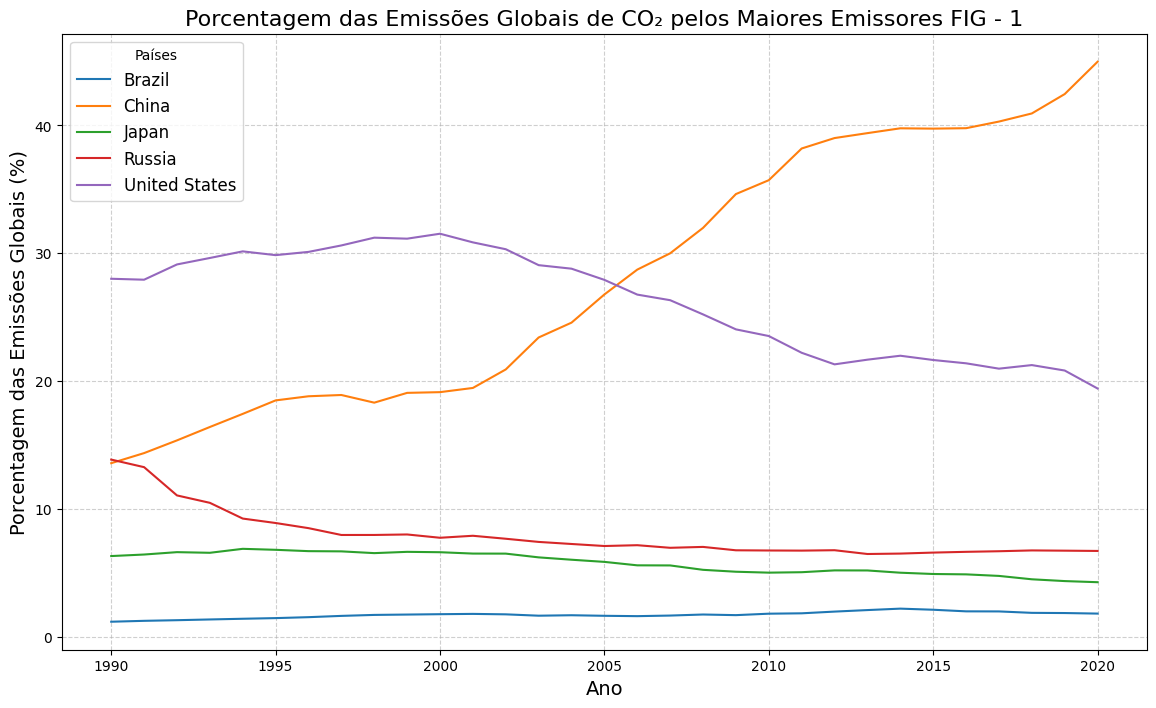

In [292]:
# Criar o gráfico para visualização das porcentagens
df_percentage.plot(figsize=(14, 8))
plt.title("Porcentagem das Emissões Globais de CO₂ pelos Maiores Emissores FIG - 1", fontsize=16)
plt.xlabel("Ano", fontsize=14)
plt.ylabel("Porcentagem das Emissões Globais (%)", fontsize=14)
plt.legend(title="Países", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Combinar os dois datasets para relacionar o aumento de temperatura com a emissão de CO2


### Agrupar os dados de temperatura por ano para calcular a média


In [293]:
df_temp_grouped = df_temp.groupby('Year', as_index=False).mean()


### Combinar os dois datasets pelo ano


In [294]:
dados_combinados = pd.merge(
    df,
    df_temperatura_global,
    left_on='year',
    right_on='Year',
    how='inner'
)


### Remover duplicatas da temperatura


In [295]:
dados_combinados = dados_combinados.drop_duplicates(subset=['year'])


### Renomear colunas para clareza

In [296]:
dados_combinados.rename(columns={'Value': 'temperature_change', 'co2': 'carbon_emissions'}, inplace=True)


### Criar o gráfico


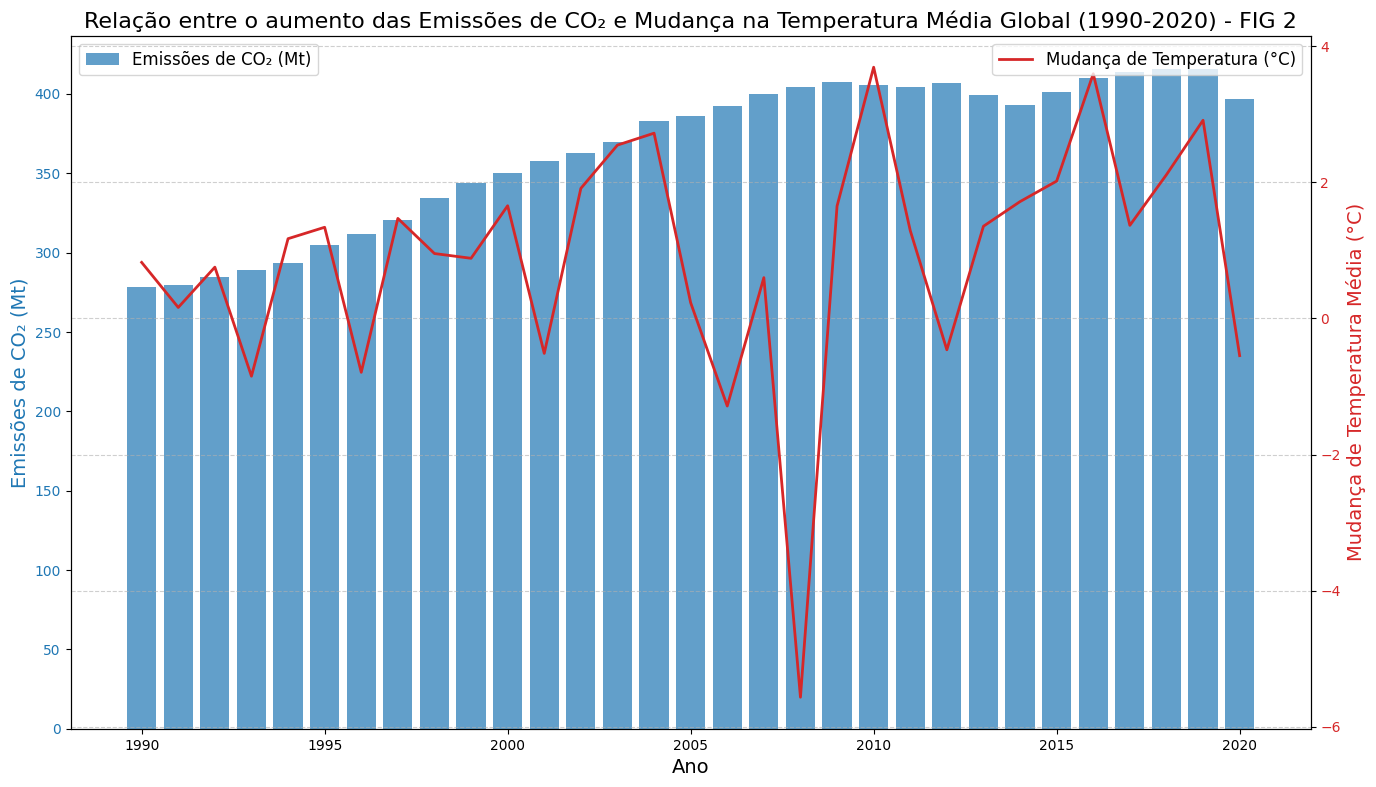

In [297]:
fig, ax1 = plt.subplots(figsize=(16, 9))

color = 'tab:blue'
ax1.set_xlabel('Ano', fontsize=14)
ax1.set_ylabel('Emissões de CO₂ (Mt)', color=color, fontsize=14)
ax1.bar(dados_combinados['year'], dados_combinados['carbon_emissions'], color=color, alpha=0.7, label='Emissões de CO₂ (Mt)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left', fontsize=12)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mudança de Temperatura Média (°C)', color=color, fontsize=14)

ax2.plot(
    dados_combinados['year'], 
    dados_combinados['temperature_change'], 
    color=color, 
    linestyle='-', 
    linewidth=2, 
    label='Mudança de Temperatura (°C)'
)

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right', fontsize=12)

plt.title('Relação entre o aumento das Emissões de CO₂ e Mudança na Temperatura Média Global (1990-2020) - FIG 2', fontsize=16)
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Exibir o gráfico
plt.show()


# Treinando modelo para projeção de temperatura baseado na emissão de CO2

### Tratamento dos dados FAOSTAT (dataset de temperatura global)



In [298]:
faostat_cleaned = df_temperatura_global[['Area', 'Year', 'Value']].copy()
faostat_cleaned.rename(columns={'Value': 'Temperature_Change'}, inplace=True)
faostat_cleaned.dropna(subset=['Temperature_Change'], inplace=True)
faostat_global_avg = faostat_cleaned.groupby('Year')['Temperature_Change'].mean().reset_index()


### Tratamento dos dados OWID (dataset de emissão de carbono)


In [299]:
owid_cleaned = df[['year', 'country', 'co2', 'population', 'temperature_change_from_co2']].copy()
owid_cleaned.dropna(subset=['co2', 'temperature_change_from_co2'], inplace=True)
owid_global_avg = owid_cleaned.groupby('year')[['co2', 'temperature_change_from_co2']].mean().reset_index()
owid_global_avg.rename(columns={'year': 'Year', 'co2': 'CO2_Emissions', 
                                 'temperature_change_from_co2': 'CO2_Temp_Change'}, inplace=True)


### Separar variáveis independentes (X) e dependente (y)


In [300]:
X = combined_data[['CO2_Emissions']]
y = combined_data['Temperature_Change']

### Dividir os dados em treino e teste


In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Treinar o modelo de regressão linear


In [302]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

### Fazer previsões

In [303]:
y_pred = model.predict(X_test)


### Avaliar o modelo no conjunto de teste


In [304]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")


Erro Quadrático Médio (MSE): 0.06
Coeficiente de Determinação (R²): 0.76


### Fazer projeções para os próximos 10 anos


In [305]:
anos_futuros = np.arange(2024, 2034).reshape(-1, 1)
emissoes_futuras = pd.DataFrame({
    'Year': anos_futuros.flatten(),
    'CO2_Emissions': np.linspace(X['CO2_Emissions'].max(), X['CO2_Emissions'].max() + 50, len(anos_futuros))  # Aumento projetado
})
temperaturas_futuras = model.predict(emissoes_futuras[['CO2_Emissions']])


### Exibir as projeções


In [306]:
projecoes = pd.DataFrame({
    'Ano': anos_futuros.flatten(),
    'Emissões de CO₂ (Mt)': emissoes_futuras['CO2_Emissions'].values,
    'Projeção de Temperatura (°C)': temperaturas_futuras
})
print("\n### Projeções para os Próximos 10 Anos ###")
print(projecoes)



### Projeções para os Próximos 10 Anos ###
    Ano  Emissões de CO₂ (Mt)  Projeção de Temperatura (°C)
0  2024            711.816381                      1.266147
1  2025            717.371937                      1.285017
2  2026            722.927492                      1.303886
3  2027            728.483048                      1.322756
4  2028            734.038603                      1.341625
5  2029            739.594159                      1.360495
6  2030            745.149714                      1.379365
7  2031            750.705270                      1.398234
8  2032            756.260825                      1.417104
9  2033            761.816381                      1.435974


### Plotar as projeções


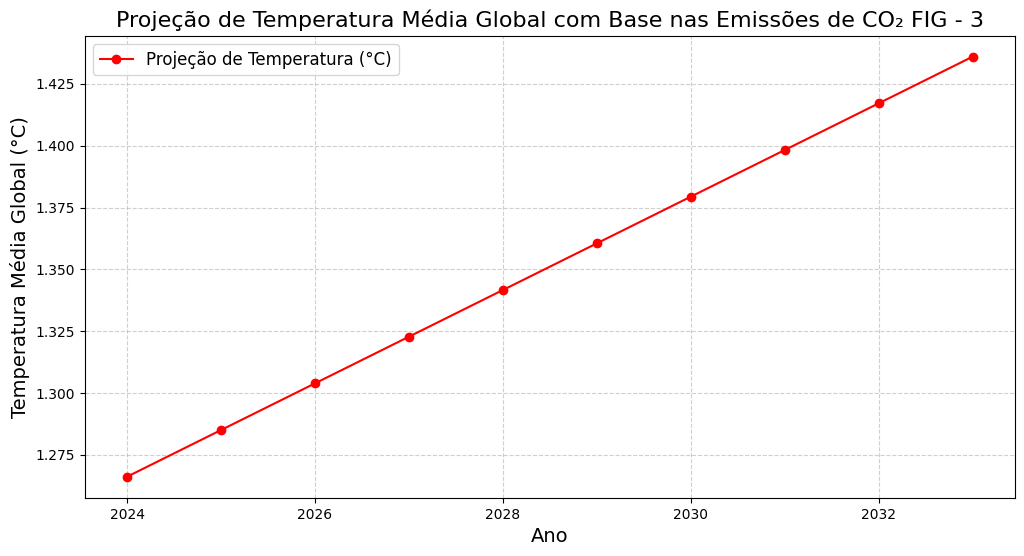

In [307]:
plt.figure(figsize=(12, 6))
plt.plot(projecoes['Ano'], projecoes['Projeção de Temperatura (°C)'], marker='o', label='Projeção de Temperatura (°C)', color='red')
plt.title('Projeção de Temperatura Média Global com Base nas Emissões de CO₂ FIG - 3', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Temperatura Média Global (°C)', fontsize=14)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()


# Integrar dados usando API, Painel de temperadura dos países em tempo real

In [308]:

# Endpoint da Open-Meteo API
BASE_URL = "https://api.open-meteo.com/v1/forecast"

# Lista de países da OCDE com suas coordenadas
countries = [
    {"country": "Australia", "latitude": -25.0, "longitude": 133.0},
    {"country": "Canada", "latitude": 56.1304, "longitude": -106.3468},
    {"country": "France", "latitude": 46.6034, "longitude": 1.8883},
    {"country": "Germany", "latitude": 51.1657, "longitude": 10.4515},
    {"country": "Italy", "latitude": 41.8719, "longitude": 12.5674},
    {"country": "Japan", "latitude": 36.2048, "longitude": 138.2529},
    {"country": "Mexico", "latitude": 23.6345, "longitude": -102.5528},
    {"country": "Spain", "latitude": 40.4637, "longitude": -3.7492},
    {"country": "United Kingdom", "latitude": 55.3781, "longitude": -3.4360},
    {"country": "United States", "latitude": 37.0902, "longitude": -95.7129},
]

# Função para buscar temperatura para cada país
def get_country_temperature(country, latitude, longitude):
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "current_weather": True,  # Obtém o clima atual
        "temperature_unit": "celsius",
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get("current_weather", {}).get("temperature", None)
    else:
        return None

# Função para atualizar os dados de temperatura
def fetch_temperatures():
    results = []
    for country in countries:
        temperature = get_country_temperature(
            country["country"], country["latitude"], country["longitude"]
        )
        results.append({"País": country["country"], "Temperatura Atual (°C)": temperature})
    return pd.DataFrame(results)

# Configuração do Dash
app = dash.Dash(__name__)
app.title = "Temperatura Atual - Países da OCDE"

# Carregar os dados iniciais
initial_data = fetch_temperatures()

# Layout do dashboard
app.layout = html.Div(
    children=[
        html.H1("Temperatura Atual - Países da OCDE", style={"textAlign": "center"}),
        dash_table.DataTable(
            id="temperature-table",
            columns=[{"name": i, "id": i} for i in initial_data.columns],
            data=initial_data.to_dict("records"),
            style_table={"width": "80%", "margin": "auto"},
            style_cell={"textAlign": "center", "padding": "10px"},
            style_header={"backgroundColor": "lightblue", "fontWeight": "bold"},
        ),
    ]
)

# Executar o servidor
if __name__ == "__main__":
    app.run_server(debug=True)


# Perguntas de Pesquisa ❓


1. #### Qual é a pegada de carbono atual do Brasil e como ela se compara à média global?

A pegada de carbono do Brasil é cerca de 2,2 toneladas de CO₂ per capita, abaixo da média global de 4,5 toneladas. Apesar disso, o país é o 5º maior emissor absoluto, responsável por 3% das emissões globais, principalmente devido ao desmatamento e agropecuária, ficando atrás da China, Estados Unidos, Índia e Rússia


2. #### Quais setores no Brasil contribuem mais para as emissões de gases de efeito estufa?


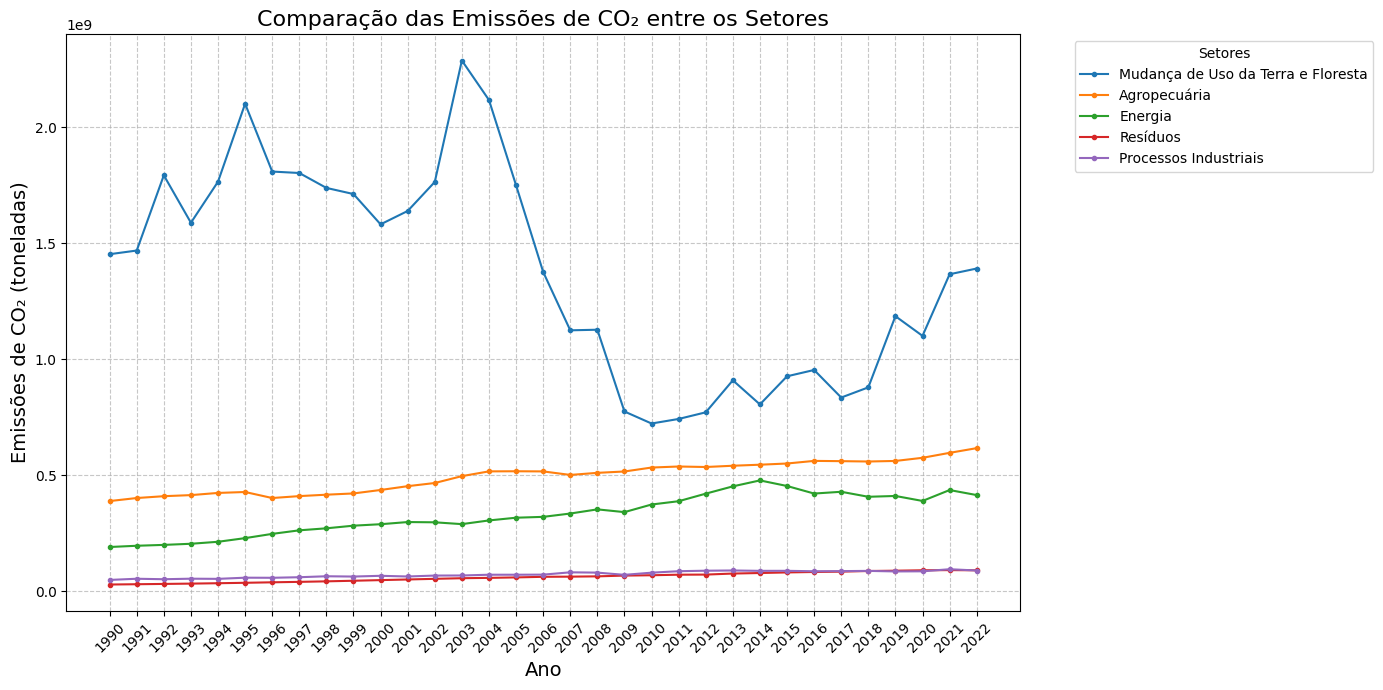

In [309]:

comparison_data = df_emissao.set_index('Categoria').iloc[:, :-1].transpose()

plt.figure(figsize=(14, 7))

for sector in comparison_data.columns:
    plt.plot(comparison_data.index, comparison_data[sector], label=sector, marker='.')

plt.title('Comparação das Emissões de CO₂ entre os Setores', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Emissões de CO₂ (toneladas)', fontsize=14)
plt.legend(title='Setores', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


R: Como mostra o gráfico acima, o setor "Mudança de Uso da Terra e Floresta" é responsavel pela maior parte de emissão de CO2 do nosso país, este setor é responsavel pela transformação de terra em ambientes para plantação e para procriação de gado, o metodo comumente usado por essas áreas são as queimadas.

3. #### Quais setores no Brasil contribuem mais para as emissões de gases de efeito estufa?


R: A pegada de carbono do Brasil é de 2,23 toneladas de CO₂ per capita, menor que a média da OCDE (5,4 toneladas) e de países das Américas como os EUA (13,8 toneladas), graças à matriz energética mais limpa.

4. #### Quais tendências de emissão o Brasil vem apresentando ao longo das últimas décadas?

R: As emissões do Brasil aumentaram até o início dos anos 2000, impulsionadas pelo desmatamento, reduziram significativamente entre 2004 e 2010 devido a políticas de controle, mas voltaram a crescer a partir de 2010, atingindo um pico em 2021 com um aumento de 12,2% em relação a 2020.


5. #### Como as emissões per capita do Brasil se comparam com as dos EUA?


R: As emissões per capita do Brasil são significativamente menores que as dos EUA. Em 2022, o Brasil emitiu cerca de 2,2 toneladas de CO₂ por pessoa, enquanto os EUA registraram aproximadamente 13,8 toneladas por pessoa, refletindo diferenças nos padrões de consumo energético e matriz energética, com o Brasil tendo maior participação de fontes renováveis.

6. #### Quais fatores podem ajudar a reduzir a pegada de carbono do Brasil?


R: Reduzir a pegada de carbono do Brasil passa por combater o desmatamento com políticas rigorosas de preservação e reflorestamento, especialmente na Amazônia, e promover uma agricultura sustentável, adotando práticas que diminuam as emissões de metano e aumentem a eficiência do uso da terra.

7. #### Como a política energética do Brasil contribui para sua pegada de carbono?


R: A política energética do Brasil reduz sua pegada de carbono devido à alta participação de fontes renováveis (46%) e uso de biocombustíveis, embora desafios como a dependência de termelétricas e desmatamento possam elevar emissões.

8. #### Qual seria o impacto da eletrificação do transporte no Brasil em termos de redução de emissões?


R: A eletrificação do transporte no Brasil pode reduzir até 90% das emissões do setor, aproveitando a matriz energética renovável, diminuindo a poluição urbana e a dependência de combustíveis fósseis.

9. #### Que papel o desmatamento na Amazônia desempenha na pegada de carbono do Brasil?


R: O desmatamento na Amazônia gera 44% das emissões do Brasil, liberando CO₂ armazenado e reduzindo a captura de carbono, sendo crucial combatê-lo para mitigar a pegada de carbono.

10.  #### Quais políticas podem ser mais eficazes para mitigar a pegada de carbono do Brasil nos próximos anos?


Para mitigar a pegada de carbono, o Brasil deve combater o desmatamento, expandir fontes renováveis como solar e eólica, promover práticas agropecuárias sustentáveis, incentivar a eletrificação do transporte e investir na gestão de resíduos, reduzindo emissões de forma integrada e eficaz.